/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 10, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,265 (75.25 KB)

 Trainable params: 19,265 (75.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 35255.7227 - mae: 185.4966 - val_loss: 36530.3516 - val_mae: 188.9536
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 34268.5898 - mae: 182.7991 - val_loss: 31300.9199 - val_mae: 174.5539
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 28499.7988 - mae: 166.2307 - val_loss: 25775.1074 - val_mae: 157.9339
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 23234.2461 - mae: 149.5523 - val_loss: 20563.4766 - val_mae: 140.4685
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18217.7129 - mae: 131.7036 - val_loss: 15601.3887 - val_mae: 121.5289
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13526.3359 - mae: 112.4806 - val_loss: 11165.5771 - val_mae: 101.6535
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9436.3604 - mae: 92.5574 - val_loss: 7514.1465 - val_mae: 81.7435
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6173.1426 - mae: 72.9194 - val_loss: 4786.

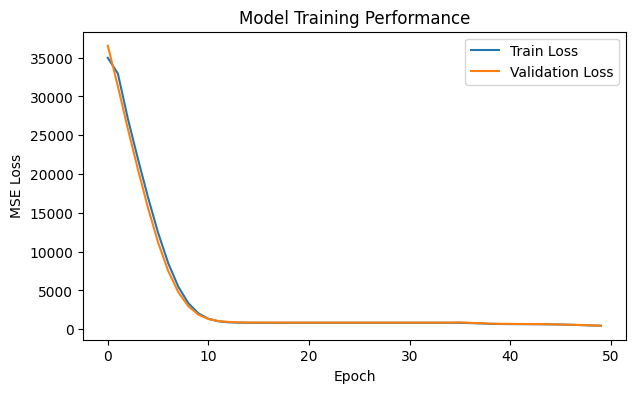

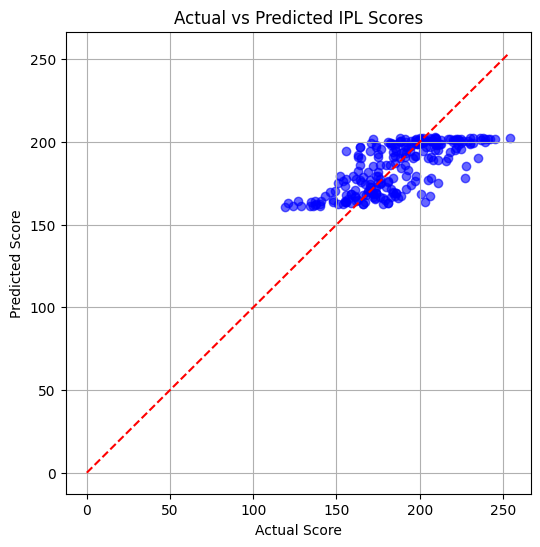


✅ Test Mean Absolute Error (MAE): 15.16 runs
Model training completed successfully!


In [1]:
# ============================================
# IPL Score Prediction using LSTM (Deep Learning)
# ============================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --------------------------------------------
# 1️ Generate Synthetic IPL-like Innings Data
# --------------------------------------------
def simulate_innings(n_innings=1200):
    innings = []
    for _ in range(n_innings):
        # random base score (e.g., 120–220)
        base = np.random.normal(170, 20)
        # progressive scoring pattern (low in start, high at end)
        over_means = np.linspace(0.6, 1.4, 20) * (base / 20.0)
        runs = np.random.poisson(lam=over_means)
        # occasional high-scoring overs
        spikes = np.random.binomial(1, 0.05, size=20)
        runs = runs + spikes * np.random.randint(6, 24, size=20)
        wickets = np.random.binomial(2, 0.25, size=20)
        total = int(runs.sum())
        innings.append({
            'runs_per_over': runs.astype(int),
            'wickets_per_over': wickets.astype(int),
            'total': total
        })
    return innings

data = simulate_innings(1200)

# --------------------------------------------
# 2️ Prepare Dataset for Training
# --------------------------------------------
SEQ_LEN = 10  # use first 10 overs to predict final score

X_seq = np.array([np.vstack((d['runs_per_over'][:SEQ_LEN], d['wickets_per_over'][:SEQ_LEN])).T for d in data])
y = np.array([d['total'] for d in data])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.2, random_state=42)

# Scale inputs
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, 2)
X_test_flat = X_test.reshape(-1, 2)
scaler.fit(X_train_flat)
X_train_scaled = scaler.transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)

# --------------------------------------------
# 3️ Build LSTM Model
# --------------------------------------------
model = Sequential([
    Masking(mask_value=0., input_shape=(SEQ_LEN, 2)),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# --------------------------------------------
# 4️ Train Model
# --------------------------------------------
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.15,
                    callbacks=[es],
                    verbose=1)

# --------------------------------------------
# 5️ Evaluate Model
# --------------------------------------------
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)
y_pred = model.predict(X_test_scaled).flatten()

# Show sample predictions
sample_df = pd.DataFrame({
    'Actual_Total': y_test,
    'Predicted_Total': np.round(y_pred).astype(int),
    'Error': (y_pred - y_test)
})
sample_df['Absolute_Error'] = sample_df['Error'].abs().round(2)
print("\nSample Predictions (Top 10):")
print(sample_df.head(10))

# --------------------------------------------
# 6️ Visualizations
# --------------------------------------------

# Plot training vs validation loss
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Performance')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Scatter: Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
maxv = max(y_test.max(), y_pred.max())
plt.plot([0, maxv], [0, maxv], '--', color='red')
plt.title('Actual vs Predicted IPL Scores')
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.grid(True)
plt.show()

# --------------------------------------------
# 7️ Print Evaluation Summary
# --------------------------------------------
print(f"\n Test Mean Absolute Error (MAE): {test_mae:.2f} runs")
print("Model training completed successfully!")
